# Method 3 - Best Ideas High Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

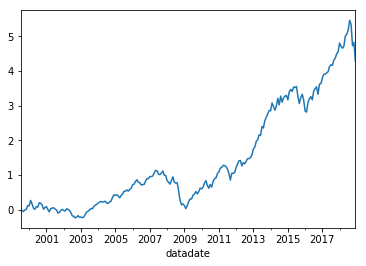

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.120033
2000-12-31   -0.051316
2001-12-31   -0.051534
2002-12-31   -0.221364
2003-12-31    0.467515
2004-12-31    0.242037
2005-12-31    0.131665
2006-12-31    0.171614
2007-12-31    0.047685
2008-12-31   -0.412328
2009-12-31    0.390131
2010-12-31    0.258453
2011-12-31    0.014915
2012-12-31    0.243986
2013-12-31    0.497230
2014-12-31    0.113172
2015-12-31   -0.030494
2016-12-31    0.111950
2017-12-31    0.198709
2018-12-31   -0.050070
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     637.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.83e-123
Time:                        13:31:09   Log-Likelihood:                 668.28
No. Observations:                 234   AIC:                            -1327.
Df Residuals:                     229   BIC:                            -1309.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.644      0.000       0.002       0.005
mktrf          0.8884      0.026     33.866      0.000       0.837       0.940
me             0.4320      0.031     14.156      0.000       0.372       0.492
ia            -0.0958      0.046     -2.067      0.040      -0.187      -0.004
roe           -0.0600      0.040     -1.511      0.132      -0.138       0.018
==============================================================================
Omnibus:                       21.109   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.805
Skew:                          -0.431   Prob(JB):                     1.87e-10
Kurtosis:                       4.963   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     518.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.83e-113
Time:                        13:31:09   Log-Likelihood:                 668.28
No. Observations:                 234   AIC:                            -1327.
Df Residuals:                     229   BIC:                            -1309.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.057      0.000       0.002       0.005
mktrf          0.8884      0.038     23.480      0.000       0.814       0.963
me             0.4320      0.035     12.276      0.000       0.363       0.501
ia            -0.0958      0.063     -1.532      0.126      -0.218       0.027
roe           -0.0600      0.061     -0.988      0.323      -0.179       0.059
==============================================================================
Omnibus:                       21.109   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.805
Skew:                          -0.431   Prob(JB):                     1.87e-10
Kurtosis:                       4.963   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     642.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.48e-123
Time:                        13:31:09   Log-Likelihood:                 668.28
No. Observations:                 234   AIC:                            -1327.
Df Residuals:                     229   BIC:                            -1309.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.672      0.000       0.002       0.005
mktrf          0.8884      0.029     30.260      0.000       0.831       0.946
me             0.4320      0.034     12.625      0.000       0.365       0.499
ia            -0.0958      0.068     -1.413      0.158      -0.229       0.037
roe           -0.0600      0.054     -1.104      0.269      -0.166       0.046
==============================================================================
Omnibus:                       21.109   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.805
Skew:                          -0.431   Prob(JB):                     1.87e-10
Kurtosis:                       4.963   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     478.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.04e-118
Time:                        13:31:09   Log-Likelihood:                 661.91
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     228   BIC:                            -1291.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.678      0.000       0.002       0.006
mktrf          0.8948      0.027     33.055      0.000       0.841       0.948
smb            0.4227      0.036     11.833      0.000       0.352       0.493
hml           -0.0603      0.042     -1.432      0.153      -0.143       0.023
rmw           -0.1150      0.048     -2.415      0.017      -0.209      -0.021
cma            0.0452      0.061      0.748      0.455      -0.074       0.165
==============================================================================
Omnibus:                       15.942   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.629
Skew:                          -0.366   Prob(JB):                     6.07e-07
Kurtosis:                       4.549   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     491.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.50e-120
Time:                        13:31:09   Log-Likelihood:                 661.91
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     228   BIC:                            -1291.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.715      0.000       0.002       0.006
mktrf          0.8948      0.038     23.503      0.000       0.820       0.969
smb            0.4227      0.042     10.076      0.000       0.340       0.505
hml           -0.0603      0.065     -0.924      0.355      -0.188       0.068
rmw           -0.1150      0.063     -1.811      0.070      -0.239       0.009
cma            0.0452      0.117      0.386      0.700      -0.185       0.275
==============================================================================
Omnibus:                       15.942   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.629
Skew:                          -0.366   Prob(JB):                     6.07e-07
Kurtosis:                       4.549   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     592.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.03e-128
Time:                        13:31:09   Log-Likelihood:                 661.91
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     228   BIC:                            -1291.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.326      0.001       0.002       0.006
mktrf          0.8948      0.036     24.904      0.000       0.824       0.965
smb            0.4227      0.040     10.549      0.000       0.344       0.501
hml           -0.0603      0.070     -0.863      0.388      -0.197       0.077
rmw           -0.1150      0.063     -1.814      0.070      -0.239       0.009
cma            0.0452      0.131      0.347      0.729      -0.211       0.301
==============================================================================
Omnibus:                       15.942   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.629
Skew:                          -0.366   Prob(JB):                     6.07e-07
Kurtosis:                       4.549   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     583.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.19e-119
Time:                        13:31:09   Log-Likelihood:                 658.82
No. Observations:                 234   AIC:                            -1308.
Df Residuals:                     229   BIC:                            -1290.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.914      0.004       0.001       0.005
mktrf          0.9547      0.025     37.964      0.000       0.905       1.004
smb            0.4159      0.031     13.248      0.000       0.354       0.478
hml            0.0220      0.031      0.705      0.482      -0.039       0.083
umd            0.0629      0.020      3.074      0.002       0.023       0.103
==============================================================================
Omnibus:                       21.840   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.934
Skew:                          -0.388   Prob(JB):                     1.94e-12
Kurtosis:                       5.220   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     762.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.15e-131
Time:                        13:31:09   Log-Likelihood:                 658.82
No. Observations:                 234   AIC:                            -1308.
Df Residuals:                     229   BIC:                            -1290.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.940      0.003       0.001       0.005
mktrf          0.9547      0.031     30.336      0.000       0.893       1.016
smb            0.4159      0.041     10.128      0.000       0.335       0.496
hml            0.0220      0.045      0.487      0.627      -0.067       0.110
umd            0.0629      0.023      2.717      0.007       0.018       0.108
==============================================================================
Omnibus:                       21.840   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.934
Skew:                          -0.388   Prob(JB):                     1.94e-12
Kurtosis:                       5.220   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     939.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.72e-141
Time:                        13:31:09   Log-Likelihood:                 658.82
No. Observations:                 234   AIC:                            -1308.
Df Residuals:                     229   BIC:                            -1290.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.849      0.004       0.001       0.005
mktrf          0.9547      0.028     34.426      0.000       0.900       1.009
smb            0.4159      0.036     11.575      0.000       0.345       0.486
hml            0.0220      0.049      0.452      0.651      -0.073       0.117
umd            0.0629      0.024      2.605      0.009       0.016       0.110
==============================================================================
Omnibus:                       21.840   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.934
Skew:                          -0.388   Prob(JB):                     1.94e-12
Kurtosis:                       5.220   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     266.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.97e-57
Time:                        13:31:09   Log-Likelihood:                 319.56
No. Observations:                 120   AIC:                            -629.1
Df Residuals:                     115   BIC:                            -615.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.659      0.100      -0.001       0.006
mktrf          0.8943      0.044     20.128      0.000       0.806       0.982
me             0.4318      0.044      9.840      0.000       0.345       0.519
ia            -0.0731      0.069     -1.064      0.290      -0.209       0.063
roe           -0.0239      0.061     -0.393      0.695      -0.144       0.097
==============================================================================
Omnibus:                        8.304   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               10.726
Skew:                          -0.377   Prob(JB):                      0.00469
Kurtosis:                       4.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     293.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.53e-59
Time:                        13:31:09   Log-Likelihood:                 319.56
No. Observations:                 120   AIC:                            -629.1
Df Residuals:                     115   BIC:                            -615.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.192      0.028       0.000       0.005
mktrf          0.8943      0.068     13.109      0.000       0.761       1.028
me             0.4318      0.048      9.017      0.000       0.338       0.526
ia            -0.0731      0.074     -0.993      0.321      -0.217       0.071
roe           -0.0239      0.086     -0.277      0.782      -0.193       0.145
==============================================================================
Omnibus:                        8.304   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               10.726
Skew:                          -0.377   Prob(JB):                      0.00469
Kurtosis:                       4.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     433.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.48e-68
Time:                        13:31:09   Log-Likelihood:                 319.56
No. Observations:                 120   AIC:                            -629.1
Df Residuals:                     115   BIC:                            -615.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.157      0.031       0.000       0.005
mktrf          0.8943      0.051     17.395      0.000       0.794       0.995
me             0.4318      0.047      9.234      0.000       0.340       0.523
ia            -0.0731      0.076     -0.959      0.337      -0.222       0.076
roe           -0.0239      0.073     -0.329      0.742      -0.167       0.119
==============================================================================
Omnibus:                        8.304   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               10.726
Skew:                          -0.377   Prob(JB):                      0.00469
Kurtosis:                       4.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     192.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.42e-54
Time:                        13:31:09   Log-Likelihood:                 314.62
No. Observations:                 120   AIC:                            -617.2
Df Residuals:                     114   BIC:                            -600.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.183      0.031       0.000       0.007
mktrf          0.9043      0.049     18.443      0.000       0.807       1.001
smb            0.4160      0.056      7.491      0.000       0.306       0.526
hml           -0.0830      0.068     -1.219      0.225      -0.218       0.052
rmw           -0.0881      0.080     -1.098      0.274      -0.247       0.071
cma            0.1109      0.088      1.261      0.210      -0.063       0.285
==============================================================================
Omnibus:                        5.294   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                4.824
Skew:                          -0.394   Prob(JB):                       0.0897
Kurtosis:                       3.587   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     281.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.04e-62
Time:                        13:31:09   Log-Likelihood:                 314.62
No. Observations:                 120   AIC:                            -617.2
Df Residuals:                     114   BIC:                            -600.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.317      0.020       0.001       0.007
mktrf          0.9043      0.078     11.591      0.000       0.751       1.057
smb            0.4160      0.061      6.868      0.000       0.297       0.535
hml           -0.0830      0.100     -0.827      0.408      -0.280       0.114
rmw           -0.0881      0.117     -0.756      0.450      -0.317       0.140
cma            0.1109      0.147      0.754      0.451      -0.177       0.399
==============================================================================
Omnibus:                        5.294   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                4.824
Skew:                          -0.394   Prob(JB):                       0.0897
Kurtosis:                       3.587   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     305.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.64e-64
Time:                        13:31:09   Log-Likelihood:                 314.62
No. Observations:                 120   AIC:                            -617.2
Df Residuals:                     114   BIC:                            -600.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.197      0.028       0.000       0.007
mktrf          0.9043      0.075     12.000      0.000       0.757       1.052
smb            0.4160      0.058      7.154      0.000       0.302       0.530
hml           -0.0830      0.108     -0.767      0.443      -0.295       0.129
rmw           -0.0881      0.122     -0.724      0.469      -0.327       0.151
cma            0.1109      0.159      0.698      0.485      -0.201       0.422
==============================================================================
Omnibus:                        5.294   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                4.824
Skew:                          -0.394   Prob(JB):                       0.0897
Kurtosis:                       3.587   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     240.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.93e-55
Time:                        13:31:09   Log-Likelihood:                 314.02
No. Observations:                 120   AIC:                            -618.0
Df Residuals:                     115   BIC:                            -604.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      2.045      0.043       0.000       0.007
mktrf          0.9703      0.041     23.671      0.000       0.889       1.052
smb            0.3950      0.047      8.463      0.000       0.303       0.487
hml            0.0317      0.047      0.678      0.499      -0.061       0.124
umd            0.0733      0.029      2.542      0.012       0.016       0.130
==============================================================================
Omnibus:                       11.760   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               16.765
Skew:                          -0.499   Prob(JB):                     0.000229
Kurtosis:                       4.535   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     462.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.56e-70
Time:                        13:31:09   Log-Likelihood:                 314.02
No. Observations:                 120   AIC:                            -618.0
Df Residuals:                     115   BIC:                            -604.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      2.140      0.032       0.000       0.007
mktrf          0.9703      0.051     18.846      0.000       0.869       1.071
smb            0.3950      0.061      6.482      0.000       0.276       0.514
hml            0.0317      0.058      0.549      0.583      -0.081       0.145
umd            0.0733      0.028      2.629      0.009       0.019       0.128
==============================================================================
Omnibus:                       11.760   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               16.765
Skew:                          -0.499   Prob(JB):                     0.000229
Kurtosis:                       4.535   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     614.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.37e-76
Time:                        13:31:09   Log-Likelihood:                 314.02
No. Observations:                 120   AIC:                            -618.0
Df Residuals:                     115   BIC:                            -604.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.352      0.019       0.001       0.006
mktrf          0.9703      0.041     23.453      0.000       0.889       1.051
smb            0.3950      0.052      7.593      0.000       0.293       0.497
hml            0.0317      0.061      0.523      0.601      -0.087       0.150
umd            0.0733      0.025      2.952      0.003       0.025       0.122
==============================================================================
Omnibus:                       11.760   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               16.765
Skew:                          -0.499   Prob(JB):                     0.000229
Kurtosis:                       4.535   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     534.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.22e-70
Time:                        13:31:09   Log-Likelihood:                 374.11
No. Observations:                 114   AIC:                            -738.2
Df Residuals:                     109   BIC:                            -724.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      4.785      0.000       0.003       0.006
mktrf          0.8864      0.027     32.432      0.000       0.832       0.941
me             0.4325      0.042     10.250      0.000       0.349       0.516
ia            -0.2259      0.059     -3.860      0.000      -0.342      -0.110
roe           -0.2219      0.051     -4.314      0.000      -0.324      -0.120
==============================================================================
Omnibus:                        0.878   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.645   Jarque-Bera (JB):                0.500
Skew:                          -0.131   Prob(JB):                        0.779
Kurtosis:                       3.191   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     686.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.81e-76
Time:                        13:31:09   Log-Likelihood:                 374.11
No. Observations:                 114   AIC:                            -738.2
Df Residuals:                     109   BIC:                            -724.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      4.009      0.000       0.002       0.007
mktrf          0.8864      0.022     40.305      0.000       0.843       0.929
me             0.4325      0.037     11.602      0.000       0.359       0.506
ia            -0.2259      0.073     -3.078      0.002      -0.370      -0.082
roe           -0.2219      0.070     -3.155      0.002      -0.360      -0.084
==============================================================================
Omnibus:                        0.878   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.645   Jarque-Bera (JB):                0.500
Skew:                          -0.131   Prob(JB):                        0.779
Kurtosis:                       3.191   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     869.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-81
Time:                        13:31:09   Log-Likelihood:                 374.11
No. Observations:                 114   AIC:                            -738.2
Df Residuals:                     109   BIC:                            -724.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      3.225      0.001       0.002       0.007
mktrf          0.8864      0.018     50.248      0.000       0.852       0.921
me             0.4325      0.039     11.107      0.000       0.356       0.509
ia            -0.2259      0.081     -2.794      0.005      -0.384      -0.067
roe           -0.2219      0.069     -3.203      0.001      -0.358      -0.086
==============================================================================
Omnibus:                        0.878   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.645   Jarque-Bera (JB):                0.500
Skew:                          -0.131   Prob(JB):                        0.779
Kurtosis:                       3.191   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     490.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.68e-72
Time:                        13:31:09   Log-Likelihood:                 382.03
No. Observations:                 114   AIC:                            -752.1
Df Residuals:                     108   BIC:                            -735.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.971      0.000       0.002       0.005
mktrf          0.9056      0.024     37.070      0.000       0.857       0.954
smb            0.4120      0.040     10.388      0.000       0.333       0.491
hml           -0.0753      0.051     -1.489      0.139      -0.176       0.025
rmw           -0.3292      0.062     -5.316      0.000      -0.452      -0.206
cma           -0.1497      0.079     -1.904      0.060      -0.306       0.006
==============================================================================
Omnibus:                        1.012   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                1.118
Skew:                          -0.195   Prob(JB):                        0.572
Kurtosis:                       2.712   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     565.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-75
Time:                        13:31:10   Log-Likelihood:                 382.03
No. Observations:                 114   AIC:                            -752.1
Df Residuals:                     108   BIC:                            -735.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.365      0.001       0.001       0.005
mktrf          0.9056      0.019     47.274      0.000       0.868       0.943
smb            0.4120      0.035     11.865      0.000       0.344       0.480
hml           -0.0753      0.046     -1.649      0.099      -0.165       0.014
rmw           -0.3292      0.054     -6.136      0.000      -0.434      -0.224
cma           -0.1497      0.078     -1.930      0.054      -0.302       0.002
==============================================================================
Omnibus:                        1.012   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                1.118
Skew:                          -0.195   Prob(JB):                        0.572
Kurtosis:                       2.712   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     761.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.91e-82
Time:                        13:31:10   Log-Likelihood:                 382.03
No. Observations:                 114   AIC:                            -752.1
Df Residuals:                     108   BIC:                            -735.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.646      0.008       0.001       0.006
mktrf          0.9056      0.019     46.590      0.000       0.867       0.944
smb            0.4120      0.032     12.888      0.000       0.349       0.475
hml           -0.0753      0.034     -2.186      0.029      -0.143      -0.008
rmw           -0.3292      0.055     -6.020      0.000      -0.436      -0.222
cma           -0.1497      0.068     -2.212      0.027      -0.282      -0.017
==============================================================================
Omnibus:                        1.012   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                1.118
Skew:                          -0.195   Prob(JB):                        0.572
Kurtosis:                       2.712   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     454.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.52e-67
Time:                        13:31:10   Log-Likelihood:                 365.30
No. Observations:                 114   AIC:                            -720.6
Df Residuals:                     109   BIC:                            -706.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.439      0.016       0.000       0.004
mktrf          0.9401      0.028     33.599      0.000       0.885       0.996
smb            0.4795      0.044     10.991      0.000       0.393       0.566
hml           -0.0461      0.045     -1.027      0.307      -0.135       0.043
umd            0.0248      0.034      0.731      0.466      -0.042       0.092
==============================================================================
Omnibus:                        0.247   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.365
Skew:                          -0.101   Prob(JB):                        0.833
Kurtosis:                       2.809   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     698.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-76
Time:                        13:31:10   Log-Likelihood:                 365.30
No. Observations:                 114   AIC:                            -720.6
Df Residuals:                     109   BIC:                            -706.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.250      0.024       0.000       0.005
mktrf          0.9401      0.020     47.055      0.000       0.901       0.979
smb            0.4795      0.044     10.890      0.000       0.393       0.566
hml           -0.0461      0.045     -1.033      0.301      -0.134       0.041
umd            0.0248      0.035      0.712      0.477      -0.043       0.093
==============================================================================
Omnibus:                        0.247   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.365
Skew:                          -0.101   Prob(JB):                        0.833
Kurtosis:                       2.809   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     810.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.39e-80
Time:                        13:31:10   Log-Likelihood:                 365.30
No. Observations:                 114   AIC:                            -720.6
Df Residuals:                     109   BIC:                            -706.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.869      0.062      -0.000       0.005
mktrf          0.9401      0.020     46.442      0.000       0.900       0.980
smb            0.4795      0.043     11.265      0.000       0.396       0.563
hml           -0.0461      0.037     -1.259      0.208      -0.118       0.026
umd            0.0248      0.035      0.705      0.481      -0.044       0.094
==============================================================================
Omnibus:                        0.247   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.365
Skew:                          -0.101   Prob(JB):                        0.833
Kurtosis:                       2.809   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""